In [79]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import sys
import os
import geopandas as gpd

from st_utils import correct_platform_panel
from st_utils import correct_tissue_names
from st_utils import get_qced_cell_id, get_processed
from constants import PIXEL_TO_UM
from constants import matching_cores_2024, matching_cores
from constants import SAMPLES, CB_COLORS_5

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')

year = '2024'

samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
    mat_cores = matching_cores_2024
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
    mat_cores = matching_cores
else:
    samples = [x for x in SAMPLES]
print (samples)

working directory: /Users/whuan/dev/ist_benchmarking
['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


In [80]:
# Generate all cell area file
all_xenium_merscope_cell_area_file = f'{wd}/data/all_xenium_merscope_cell_area_{year}.parquet.gzip'

if os.path.isfile(all_xenium_merscope_cell_area_file):
    print (f'{all_xenium_merscope_cell_area_file} is generated.')
           
else:
    gdf_all = gpd.read_parquet(f'{wd}/data/all_xenium_merscope_cosmx_segmentation_{year}.parquet.gzip')
    gdf_plot_all = gdf_all.copy()
    gdf_plot_all = gdf_plot_all[~gdf_plot_all['Sample'].str.contains('cosmx')]
    gdf_plot_all['Platform'] = gdf_plot_all['Sample'].apply(lambda x: x.split("_")[-3].upper())
    gdf_plot_all['area_sqpx'] = gdf_plot_all['geometry'].area
    gdf_plot_all['area_squm'] = gdf_plot_all.apply(
        lambda row:row['area_sqpx'] * PIXEL_TO_UM[row['Platform'].lower()] * PIXEL_TO_UM[row['Platform'].lower()] if row['Platform'] == 'COSMX' else row['area_sqpx'],
        axis=1)
    df_area_all = gdf_plot_all[['cell_id', 'core', 'tissue_type', 'Sample', 'area_squm']]
    df_area_all.to_parquet(f'{wd}/data/all_xenium_merscope_cell_area_{year}.parquet.gzip', compression='gzip', index=False)

/Users/whuan/dev/ist_benchmarking/data/all_xenium_merscope_cell_area_2024.parquet.gzip is generated.


In [81]:
                                                                                                                                                                                                            # Get CosMx cell area 
df_area_before = pd.DataFrame()
for sample in samples:
    if 'cosmx' in sample:
        print (sample)
        df_c = get_processed(sample, 'cell_level')[['cell_id','core','tissue_type','Area']]
        df_c = correct_tissue_names(sample,df_c)
        df_c = df_c.rename(columns={'Area':'area_squm'})
        df_c['area_squm'] = df_c['area_squm'] * 0.12**2
        df_c['Sample'] = sample
        df_c = df_c[['cell_id','core','tissue_type','Sample','area_squm']]
        df_area_before = pd.concat([df_area_before, df_c])

# Get Xenium and Merscope cell area
df_xe_mer = pd.read_parquet(all_xenium_merscope_cell_area_file, engine='pyarrow')

for sample in samples:
    if 'cosmx' not in sample:
        print (sample)
        df_xe_mer_single = df_xe_mer.loc[df_xe_mer['Sample']==sample]
        df_xe_mer_single = correct_tissue_names(sample,df_xe_mer_single)
        df_area_before = pd.concat([df_area_before, df_xe_mer_single], ignore_index=False)

2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2
2024_xenium_breast_htma
2024_xenium_breast_tumor2
2024_merscope_breast_htma
2024_merscope_breast_tumor2


# Load data

In [82]:
ids, _ = get_qced_cell_id(10,0)

df_area_before.core = df_area_before.core.astype('int')
df_area_before['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
df_area_before.core = df_area_before.core.astype('str')
df_area_before = df_area_before.loc[~df_area_before['tissue_type'].isin(['Marker','MARKER'])]
df_area_before = df_area_before.drop_duplicates()
df_area_before['Filtration'] = 'Before'

df_area_after = df_area_before.loc[df_area_before['cell_id'].isin(ids)]
df_area_after['Filtration'] = 'After'

df_area_all = pd.concat([df_area_before, df_area_after])
df_area_all['TMA'] = df_area_all['Sample'].apply(lambda x: x.split('_')[-1].upper())
df_area_all = df_area_all.sort_values(by=['Sample'])
df_area_all['Platform_Panel'] = df_area_all['Sample'].apply(lambda x: f"{x.split('_')[-3].upper()}_{x.split('_')[-2].capitalize()}")
df_area_all = correct_platform_panel(df_area_all, 'Platform_Panel')
df_area_all = df_area_all.reset_index()
mat_cores = [str(x) for x in mat_cores]
df_area_all = df_area_all.loc[df_area_all['core'].isin(mat_cores)]

In [83]:
df = df_area_all.rename(columns={"tissue_type":"Tissue Type"})
grouped_df = df[['Tissue Type', 'Platform_Panel', 'area_squm']].groupby(['Tissue Type', 'Platform_Panel']).median().reset_index()
pivoted_df = grouped_df.pivot_table(index='Tissue Type', columns='Platform_Panel', values='area_squm')
# pivoted_df.to_csv(f'{wd}/tables/cell_area_{year}.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


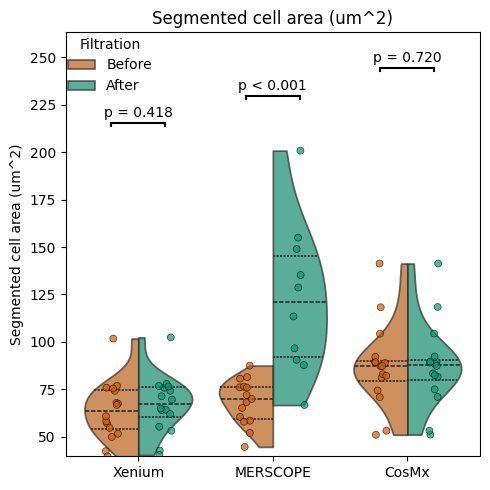

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import numpy as np
import itertools

df_plot = df.copy()
df_plot = df_plot[['Tissue Type', 'Platform_Panel', 'area_squm', 'Filtration', 'TMA']].groupby(['Tissue Type', 'Platform_Panel', 'Filtration', 'TMA']).median().reset_index()

df_plot['Platform'] = df_plot['Platform_Panel'].apply(lambda x: x.split(',')[0])

metrics = ['area_squm']

# One color per platform, plus "Before"/"After" for the split halves
palette = {
    'Xenium':   CB_COLORS_5['blue_dark'],
    'MERSCOPE': CB_COLORS_5['red'],
    'CosMx':    CB_COLORS_5['green'],
    'After':   CB_COLORS_5['green'],
    'Before':    CB_COLORS_5['red']
}

fig, ax = plt.subplots(figsize=(5, 5))

for metric in metrics:
    subset = df_plot.copy()
    platform_order = ['Xenium', 'MERSCOPE', 'CosMx']

    # Violin plot (split by Filtration)
    violin = sns.violinplot(
        x='Platform',
        y=metric,
        data=subset,
        hue='Filtration',
        split=True,
        palette=palette,
        order=platform_order,
        hue_order=['Before', 'After'],
        cut=0,
        scale='width',
        inner='quart',
        alpha=0.7,
        ax=ax
    )

    # Strip plot (show individual data points)
    strip = sns.stripplot(
        x='Platform',
        y=metric,
        data=subset,
        hue='Filtration',
        palette=palette,
        order=platform_order,
        hue_order=['Before', 'After'],
        dodge=True,            # separate points by Filtration
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        ax=ax
    )

    # Remove duplicate legend on the axes
    ax.legend_.remove()

    ax.set_title(f"Segmented cell area (um^2)")
    ax.set_xlabel("")
    ax.set_ylabel(f"Segmented cell area (um^2)")

    # Dictionary mapping platform -> x-position
    x_positions = {p: idx for idx, p in enumerate(platform_order)}
    y_max = subset[metric].max()
    y_min = subset[metric].min()
    
    # We'll keep track of how far to shift each bracket vertically
    bracket_step = 0.09 * (y_max - y_min) if (y_max - y_min) != 0 else 0.08
    bracket_count = 0

    # ----------------------------------------------------------------------
    # ONLY: Stats *within* each platform (Before vs. After)
    # ----------------------------------------------------------------------
    for p in platform_order:
        data_before = subset.loc[
            (subset['Platform'] == p) & (subset['Filtration'] == 'Before'),
            metric
        ]
        data_after = subset.loc[
            (subset['Platform'] == p) & (subset['Filtration'] == 'After'),
            metric
        ]
        # If either group is empty, skip
        if data_before.empty or data_after.empty:
            continue
        
        # Mann-Whitney test for Before vs After within this platform
        bracket_count += 1
        bracket_y = y_max + bracket_count * bracket_step

        x_center = x_positions[p]
        # We'll assume ~0.2 offset from x_center for half-violin
        x_left = x_center - 0.2
        x_right = x_center + 0.2

        stat, pval = sp.mannwhitneyu(data_before, data_after, alternative='two-sided')

        # Horizontal bracket (from x_left to x_right)
        ax.plot([x_left, x_right], [bracket_y, bracket_y], lw=1.5, color='black')
        # Vertical ticks
        tick_height = 0.01 * (y_max - y_min)
        ax.plot([x_left, x_left], [bracket_y, bracket_y - tick_height], lw=1.5, color='black')
        ax.plot([x_right, x_right], [bracket_y, bracket_y - tick_height], lw=1.5, color='black')

        # Format the p-value text
        if pval < 0.001:
            p_text = "p < 0.001"
        else:
            p_text = f"p = {pval:.3f}"

        ax.text(
            0.5*(x_left + x_right),
            bracket_y + tick_height,
            p_text,
            ha='center', va='bottom',
            fontsize=10, color='black'
        )

    # Expand y-limits to ensure all brackets are visible
    ax.set_ylim(y_min, y_max + (bracket_count + 1.3) * bracket_step)

# Create a single legend (handles/labels from the violin plot),
# slicing to keep only "Before" and "After" if there's something else in the list.
handles, labels = violin.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]

fig.legend(
    handles,
    labels,
    title="Filtration",
    loc='upper left',
    bbox_to_anchor=(0.12, 0.94),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.savefig(f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_area_violin_{year}.png', bbox_inches='tight', transparent=True)
plt.savefig(f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_area_violin_{year}.eps', bbox_inches='tight', transparent=True)  
plt.show()


In [85]:
df_plot['Year'] = year
df_plot.to_csv(f'{wd}/tables/cell_area_{year}_data.csv', index=False)
df_plot.shape

(89, 7)

In [86]:
df_plot.sort_values(by=['Platform','TMA','Tissue Type', 'Filtration'])

,Tissue Type,Platform_Panel,Filtration,TMA,area_squm,Platform,Year
0,BlC,"CosMx,1k",After,HTMA,89.539200,CosMx,2024
2,BlC,"CosMx,1k",Before,HTMA,89.467200,CosMx,2024
14,CRC,"CosMx,1k",After,HTMA,74.952000,CosMx,2024
16,CRC,"CosMx,1k",Before,HTMA,74.347200,CosMx,2024
1,BlC,"CosMx,1k",After,TUMOR2,81.561600,CosMx,2024
3,BlC,"CosMx,1k",Before,TUMOR2,81.122400,CosMx,2024
9,BrC,"CosMx,1k",After,TUMOR2,83.318400,CosMx,2024
10,BrC,"CosMx,1k",Before,TUMOR2,82.929600,CosMx,2024
15,CRC,"CosMx,1k",After,TUMOR2,70.963200,CosMx,2024
17,CRC,"CosMx,1k",Before,TUMOR2,70.833600,CosMx,2024


# Plot

In [24]:

# fontsize = 40
# width = 1100
# height = 750
# plot_metric = 'area_squm'
# groupby = 'Platform_Panel'
# val_range = [-5,300]

# df = df_area_all.copy()

# fig = go.Figure()
# fig.add_trace(go.Violin(x=df[groupby][df['Filtration'] == 'Before'],
#                         y=df[f'{plot_metric}'][df['Filtration'] == 'Before'],
#                         legendgroup='Yes', scalegroup='Yes', name='Before',
#                         side='negative',
#                         line_color='red',
#                         showlegend=True)
#              )
# fig.add_trace(go.Violin(x=df[groupby][df['Filtration'] == 'After'],
#                         y=df[f'{plot_metric}'][df['Filtration'] == 'After'],
#                         legendgroup='No', scalegroup='No', name='After',
#                         side='positive',
#                         line_color='green',
#                         showlegend=True)
#              )
# fig.update_traces(meanline_visible=True)
# fig.update_yaxes(title_text=f"Segmented cell area (um^2)",
#                 title_font=dict(size=fontsize), range=val_range, tickfont=dict(size=fontsize-2), showline=True, linewidth=2, linecolor='black')
# fig.update_xaxes(title_text="", tickfont=dict(size=fontsize-2), showline=True, linewidth=2, linecolor='black')

# fig.update_layout(
#     violingap=0.35,  # Set the gap between violins
#     violinmode='overlay',  # Overlay mode for violins
#     width=width,  # Set the width of the figure
#     height=height,  # Set the height of the figure
#     legend=dict(
#         orientation="h",  # horizontal alignment
#         yanchor="bottom", 
#         y=0.8,  # position legend just above the plot
#         xanchor="right",
#         x=0.70  # center the legend
#     ),
#     font=dict(color='black', size=fontsize),
#     paper_bgcolor='rgba(0,0,0,0)',
#     plot_bgcolor='rgba(0,0,0,0)',
# )

# fig.show()
# # pio.write_image(fig, f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_area.png', scale=4, width=width, height=height)
# pio.write_image(fig, f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_area.eps', scale=4, width=width, height=height)
# pio.write_image(fig, f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_area.svg', scale=4, width=width, height=height)
